# Custom Mask R-CNN Training

Training notebook for custom Mask R-CNN with EfficientNet backbone and CBAM attention.


In [1]:
!git clone https://github.com/michaelo-ponteski/isaid-instance-segmentation.git
%cd isaid-instance-segmentation/

Cloning into 'isaid-instance-segmentation'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 209 (delta 83), reused 171 (delta 57), pack-reused 0 (from 0)
Receiving objects: 100% (209/209), 4.05 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/isaid-instance-segmentation


In [2]:
!git pull origin ponteski

From https://github.com/michaelo-ponteski/isaid-instance-segmentation
 * branch            ponteski   -> FETCH_HEAD
Updating ebf8d65..c1347ee
Fast-forward
 .gitignore                  |   11 +
 config.yaml                 |   22 +
 datasets/isaid_dataset.py   |  138 +++-
 models/__init__.py          |   35 ++
 models/backbone.py          |  230 +++++++
 models/maskrcnn_model.py    |  365 ++++++-----
 models/roi_heads.py         |  226 +++++++
 notebooks/00_setup.ipynb    |  884 +++++++++++++-------------
 notebooks/01_training.ipynb | 1468 +++++++++++++++++++++++++++++++++++++++++++
 requirements.txt            |    9 +
 training/__init__.py        |    4 +
 training/trainer.py         |  471 ++++++++++++++
 training/transforms.py      |   48 ++
 utils/__init__.py           |    7 +
 utils/overfit_test.py       |   47 +-
 15 files changed, 3340 insertions(+), 625 deletions(-)
 create mode 100644 .gitignore
 create mode 100644 config.yaml
 create mode 100644 models/backbone.py
 create m

In [3]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("michaeloponteski/isaid-patches")

print("Path to dataset files:", path)

100%|██████████| 41.1G/41.1G [04:13<00:00, 174MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/michaeloponteski/isaid-patches/versions/1


In [4]:
import torch
import matplotlib.pyplot as plt
import importlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


In [5]:
# Reload modules for development
import datasets.isaid_dataset
import models.maskrcnn_model
import utils.overfit_test
import training.trainer
import training.transforms

importlib.reload(datasets.isaid_dataset)
importlib.reload(models.maskrcnn_model)
importlib.reload(utils.overfit_test)
importlib.reload(training.trainer)
importlib.reload(training.transforms)

from datasets.isaid_dataset import iSAIDDataset, visualize_sample
from models.maskrcnn_model import get_custom_maskrcnn
from utils.overfit_test import overfit_single_image_test
from training import Trainer

## Load Dataset


In [6]:
root_dir = path + "/iSAID_patches"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 16

In [7]:
train_dataset = iSAIDDataset(root_dir, split="train")
val_dataset = iSAIDDataset(root_dir, split="val")

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Filtered dataset: 18732 images with annotations
Filtered dataset: 6048 images with annotations
Train: 18732, Val: 6048


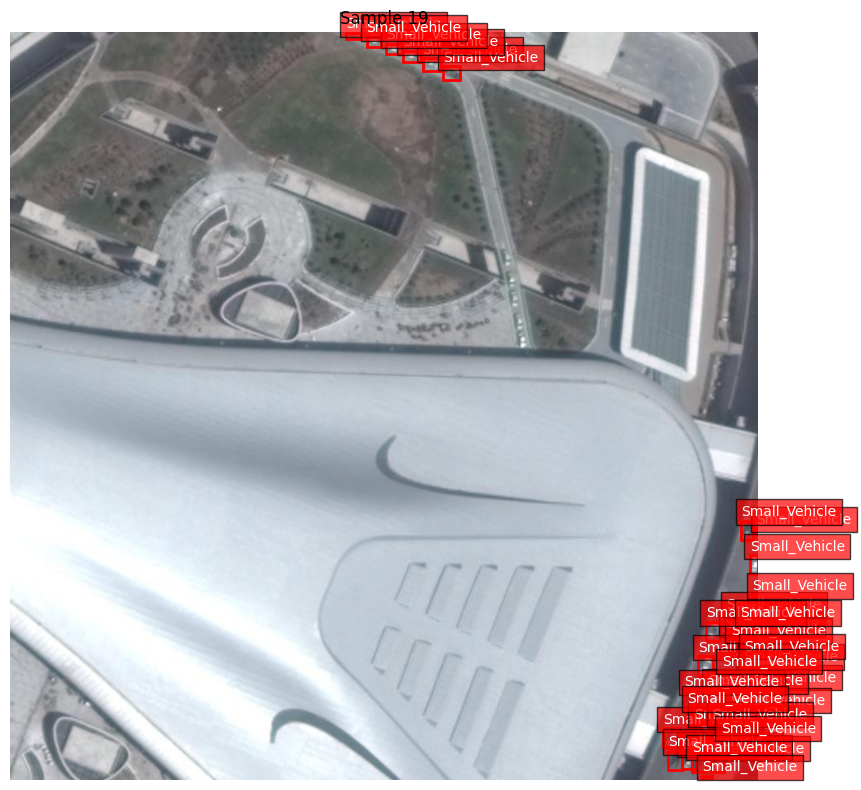

In [8]:
# Visualize a sample
visualize_sample(train_dataset, 19)

## Create Model


In [9]:
model = get_custom_maskrcnn(num_classes=num_classes, pretrained_backbone=True)

# Model info
info = model.get_model_info()
print(f"Total parameters: {info['total_parameters']:,}")
print(f"Trainable parameters: {info['trainable_parameters']:,}")
print(f"Model size: {info['model_size_mb']:.1f} MB")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 63.1MB/s]


Total parameters: 24,315,626
Trainable parameters: 24,315,626
Model size: 92.9 MB


## Overfit Single Image Test

Sanity check - can the model learn to overfit a single image?


OVERFIT SINGLE IMAGE TEST

Image shape: torch.Size([3, 800, 800])
Number of instances: 33
Classes: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

Training for 500 epochs...
Epoch [10/500], Loss: 2.3978
  loss_objectness: 0.6702
  loss_rpn_box_reg: 0.0644
  loss_classifier: 0.9372
  loss_box_reg: 0.0984
  loss_mask: 0.6276
Epoch [20/500], Loss: 1.6384
  loss_objectness: 0.6171
  loss_rpn_box_reg: 0.0567
  loss_classifier: 0.3245
  loss_box_reg: 0.2715
  loss_mask: 0.3686
Epoch [30/500], Loss: 1.3163
  loss_objectness: 0.5361
  loss_rpn_box_reg: 0.0488
  loss_classifier: 0.1933
  loss_box_reg: 0.2912
  loss_mask: 0.2469
Epoch [40/500], Loss: 1.2575
  loss_objectness: 0.4566
  loss_rpn_box_reg: 0.0466
  loss_classifier: 0.1779
  loss_box_reg: 0.2585
  loss_mask: 0.3179
Epoch [50/500], Loss: 1.1270
  loss_objectness: 0.3329
  loss_rpn_box_reg: 0.0342
  loss_classifier: 0.0993
  loss_box_reg: 0.4901
  loss_mask: 0.1705
Epoch [60/500], Lo

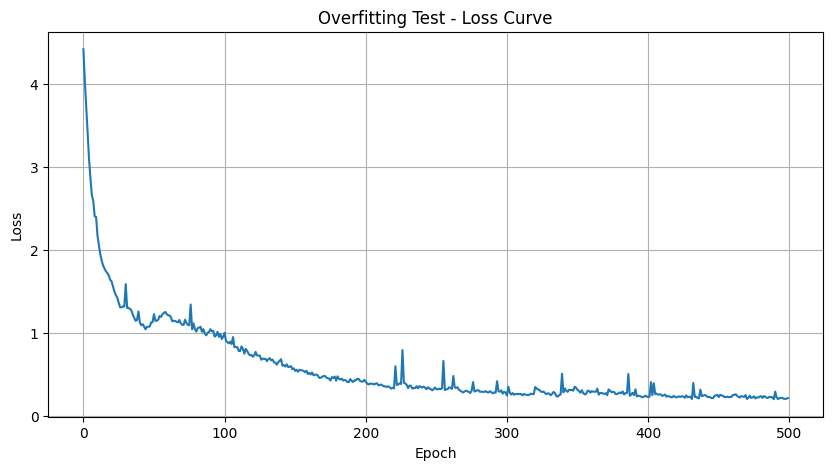

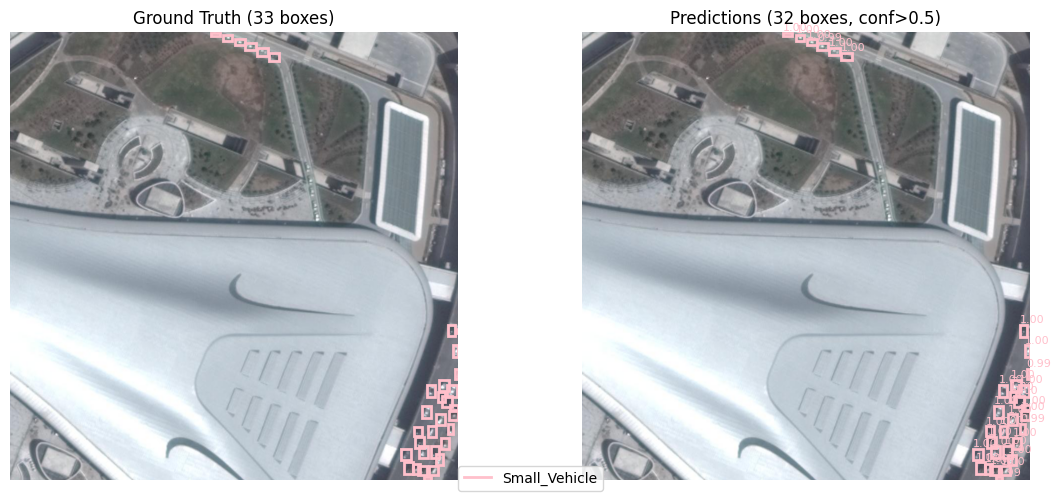


Found 32 boxes (should be 33)

RESULTS:
Initial Loss: 4.4214
Final Loss: 0.2127
Improvement: 95.2%


In [10]:
losses, preds = overfit_single_image_test(
    model, train_dataset, idx=19, num_epochs=500, device=device
)

## Training

Full training with the Trainer class.


In [11]:
# Re-create model (fresh weights)
model = get_custom_maskrcnn(num_classes=num_classes, pretrained_backbone=True)

In [12]:
trainer = Trainer(
    data_root=root_dir,
    num_classes=num_classes,
    batch_size=8,
    lr=0.0001,
    device=device,
    use_amp=True,
    subset_fraction=1,
)

Loading datasets...
Filtered dataset: 18732 images with annotations
Filtered dataset: 6048 images with annotations
Using full dataset: 18732 train, 6048 val samples
Creating model...
Device: cuda
AMP enabled: True
Train samples: 18732
Val samples: 6048


In [ ]:
trainer.fit(epochs=20, save_dir="checkpoints")


Epoch 1/20


Train Epoch 1:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 1 Results (Time: 1356.9s):
  Train Losses:
    loss_objectness: 0.2901
    loss_rpn_box_reg: 0.0914
    loss_classifier: 0.3003
    loss_box_reg: 0.0745
    loss_mask: 0.5031
    total: 1.2594
  Val Losses:
    loss_objectness: 0.2502
    loss_rpn_box_reg: 0.0922
    loss_classifier: 0.5278
    loss_box_reg: 0.2750
    loss_mask: 0.4638
    total: 1.6091
-> New best model saved

Epoch 2/20


Train Epoch 2:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 2 Results (Time: 1285.7s):
  Train Losses:
    loss_objectness: 0.2343
    loss_rpn_box_reg: 0.0811
    loss_classifier: 0.2676
    loss_box_reg: 0.1091
    loss_mask: 0.4823
    total: 1.1743
  Val Losses:
    loss_objectness: 0.2159
    loss_rpn_box_reg: 0.0862
    loss_classifier: 0.4574
    loss_box_reg: 0.2712
    loss_mask: 0.4368
    total: 1.4675
-> New best model saved

Epoch 3/20


Train Epoch 3:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 3 Results (Time: 1281.6s):
  Train Losses:
    loss_objectness: 0.2182
    loss_rpn_box_reg: 0.0776
    loss_classifier: 0.2472
    loss_box_reg: 0.1187
    loss_mask: 0.4751
    total: 1.1368
  Val Losses:
    loss_objectness: 0.2243
    loss_rpn_box_reg: 0.0857
    loss_classifier: 0.4632
    loss_box_reg: 0.2667
    loss_mask: 0.4249
    total: 1.4648
-> New best model saved

Epoch 4/20


Train Epoch 4:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 4 Results (Time: 1270.8s):
  Train Losses:
    loss_objectness: 0.2092
    loss_rpn_box_reg: 0.0754
    loss_classifier: 0.2339
    loss_box_reg: 0.1212
    loss_mask: 0.4701
    total: 1.1098
  Val Losses:
    loss_objectness: 0.2146
    loss_rpn_box_reg: 0.0863
    loss_classifier: 0.3946
    loss_box_reg: 0.2656
    loss_mask: 0.4237
    total: 1.3847
-> New best model saved

Epoch 5/20


Train Epoch 5:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 5 Results (Time: 1267.9s):
  Train Losses:
    loss_objectness: 0.2035
    loss_rpn_box_reg: 0.0736
    loss_classifier: 0.2256
    loss_box_reg: 0.1223
    loss_mask: 0.4648
    total: 1.0897
  Val Losses:
    loss_objectness: 0.2438
    loss_rpn_box_reg: 0.0849
    loss_classifier: 0.4144
    loss_box_reg: 0.2364
    loss_mask: 0.4096
    total: 1.3892

Epoch 6/20


Train Epoch 6:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 6 Results (Time: 1263.8s):
  Train Losses:
    loss_objectness: 0.2001
    loss_rpn_box_reg: 0.0723
    loss_classifier: 0.2203
    loss_box_reg: 0.1239
    loss_mask: 0.4605
    total: 1.0769
  Val Losses:
    loss_objectness: 0.2327
    loss_rpn_box_reg: 0.0844
    loss_classifier: 0.3747
    loss_box_reg: 0.2509
    loss_mask: 0.4019
    total: 1.3446
-> New best model saved

Epoch 7/20


Train Epoch 7:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 7 Results (Time: 1273.5s):
  Train Losses:
    loss_objectness: 0.1962
    loss_rpn_box_reg: 0.0712
    loss_classifier: 0.2169
    loss_box_reg: 0.1258
    loss_mask: 0.4568
    total: 1.0669
  Val Losses:
    loss_objectness: 0.2560
    loss_rpn_box_reg: 0.0850
    loss_classifier: 0.4062
    loss_box_reg: 0.2475
    loss_mask: 0.3963
    total: 1.3911

Epoch 8/20


Train Epoch 8:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 8 Results (Time: 1254.4s):
  Train Losses:
    loss_objectness: 0.1925
    loss_rpn_box_reg: 0.0701
    loss_classifier: 0.2132
    loss_box_reg: 0.1300
    loss_mask: 0.4540
    total: 1.0598
  Val Losses:
    loss_objectness: 0.2294
    loss_rpn_box_reg: 0.0848
    loss_classifier: 0.3686
    loss_box_reg: 0.2559
    loss_mask: 0.3879
    total: 1.3267
-> New best model saved

Epoch 9/20


Train Epoch 9:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 9 Results (Time: 1262.3s):
  Train Losses:
    loss_objectness: 0.1909
    loss_rpn_box_reg: 0.0693
    loss_classifier: 0.2093
    loss_box_reg: 0.1297
    loss_mask: 0.4523
    total: 1.0515
  Val Losses:
    loss_objectness: 0.2463
    loss_rpn_box_reg: 0.0852
    loss_classifier: 0.3812
    loss_box_reg: 0.2426
    loss_mask: 0.3933
    total: 1.3486

Epoch 10/20


Train Epoch 10:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 10 Results (Time: 1290.2s):
  Train Losses:
    loss_objectness: 0.1888
    loss_rpn_box_reg: 0.0684
    loss_classifier: 0.2057
    loss_box_reg: 0.1304
    loss_mask: 0.4481
    total: 1.0415
  Val Losses:
    loss_objectness: 0.2467
    loss_rpn_box_reg: 0.0836
    loss_classifier: 0.3993
    loss_box_reg: 0.2428
    loss_mask: 0.3912
    total: 1.3635

Epoch 11/20


Train Epoch 11:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 11 Results (Time: 1283.9s):
  Train Losses:
    loss_objectness: 0.1837
    loss_rpn_box_reg: 0.0662
    loss_classifier: 0.1948
    loss_box_reg: 0.1305
    loss_mask: 0.4453
    total: 1.0205
  Val Losses:
    loss_objectness: 0.2633
    loss_rpn_box_reg: 0.0840
    loss_classifier: 0.3174
    loss_box_reg: 0.2315
    loss_mask: 0.3825
    total: 1.2786
-> New best model saved

Epoch 12/20


Train Epoch 12:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 12 Results (Time: 1271.6s):
  Train Losses:
    loss_objectness: 0.1821
    loss_rpn_box_reg: 0.0656
    loss_classifier: 0.1932
    loss_box_reg: 0.1313
    loss_mask: 0.4412
    total: 1.0134
  Val Losses:
    loss_objectness: 0.2677
    loss_rpn_box_reg: 0.0838
    loss_classifier: 0.3197
    loss_box_reg: 0.2284
    loss_mask: 0.3805
    total: 1.2802

Epoch 13/20


Train Epoch 13:   0%|          | 0/2341 [00:00<?, ?it/s]

Validation:   0%|          | 0/6048 [00:00<?, ?it/s]


Epoch 13 Results (Time: 1278.9s):
  Train Losses:
    loss_objectness: 0.1814
    loss_rpn_box_reg: 0.0653
    loss_classifier: 0.1929
    loss_box_reg: 0.1321
    loss_mask: 0.4417
    total: 1.0134
  Val Losses:
    loss_objectness: 0.2657
    loss_rpn_box_reg: 0.0842
    loss_classifier: 0.3200
    loss_box_reg: 0.2285
    loss_mask: 0.3792
    total: 1.2776
-> New best model saved

Epoch 14/20


Train Epoch 14:   0%|          | 0/2341 [00:00<?, ?it/s]

## Load Best Model and Evaluate

Load the best checkpoint and evaluate on validation set.


In [ ]:
# Load best checkpoint
checkpoint = trainer.load_checkpoint("checkpoints/best.pth")
trainer.model.eval()
print("Loaded best model")

In [ ]:
# Evaluate on validation set
val_losses = trainer.validate()
print("\nValidation Results:")
for k, v in val_losses.items():
    print(f"  {k}: {v:.4f}")

## Visualize


In [ ]:
# Visualize predictions on validation set
trainer.visualize_predictions(num_samples=5, score_threshold=0.5)

In [ ]:
# Quick inference on a single sample
from training.transforms import get_transforms

idx = 50
image, target = val_dataset[idx]
image_tensor = (
    get_transforms(train=False)(image) if not isinstance(image, torch.Tensor) else image
)

with torch.no_grad():
    pred = trainer.model([image_tensor.to(device)])[0]

print(f"Found {len(pred['boxes'])} detections")
print(f"Ground truth has {len(target['boxes'])} objects")